## The Quantum Convolution Neural Network (Connect to Pytorch)
Refference: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

<img src="../../assets/QCNN.png" width="auto" height="300" alt="Alt text">

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.connectors import TorchConnector

algorithm_globals.random_seed = 111
torch.manual_seed(111)

# Convolutional Layer

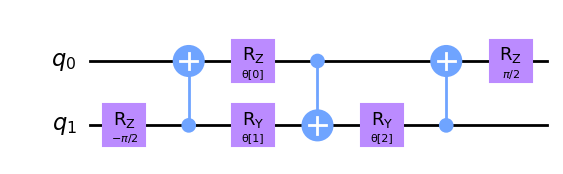

In [34]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

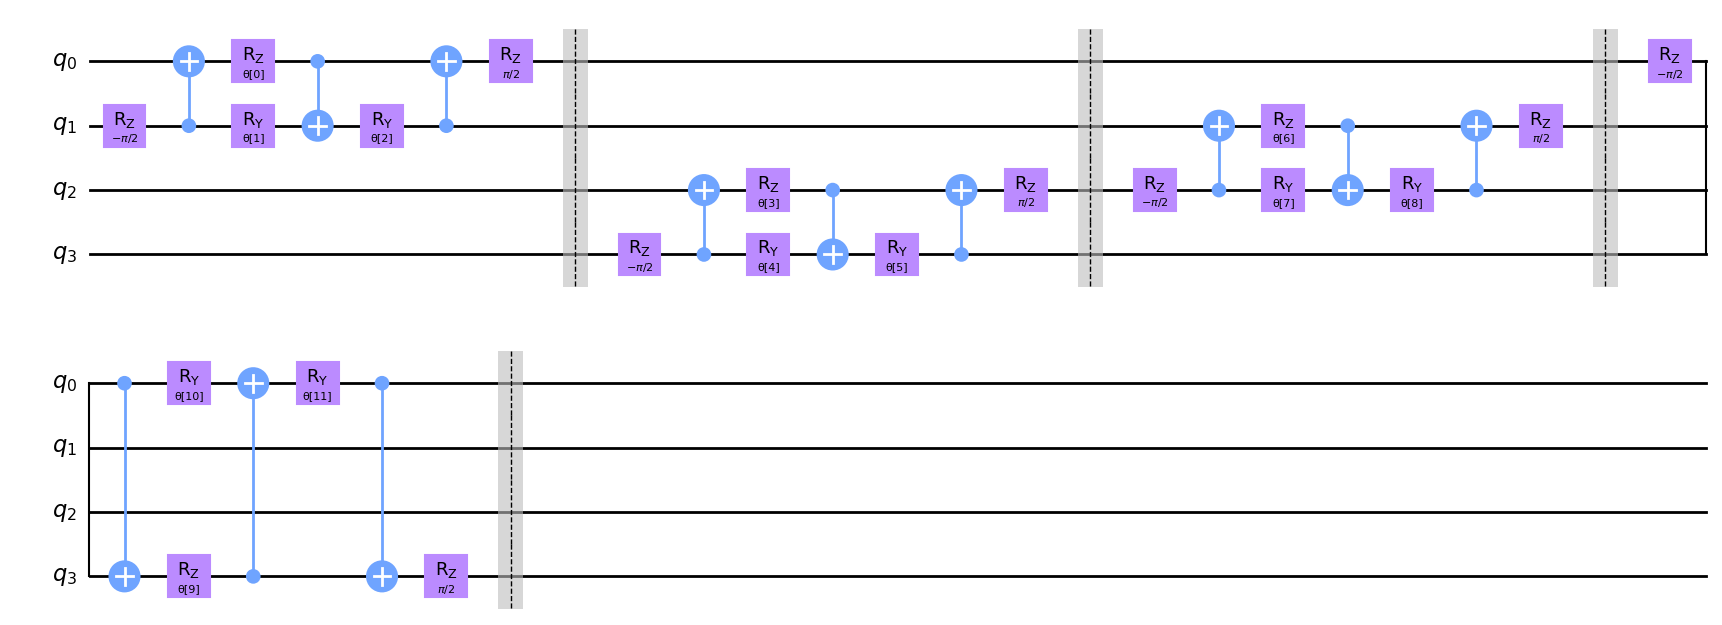

In [35]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

# Pooling Layer

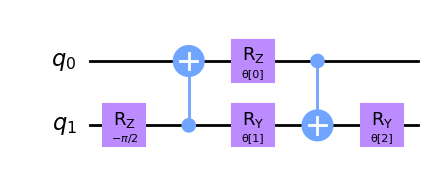

In [36]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

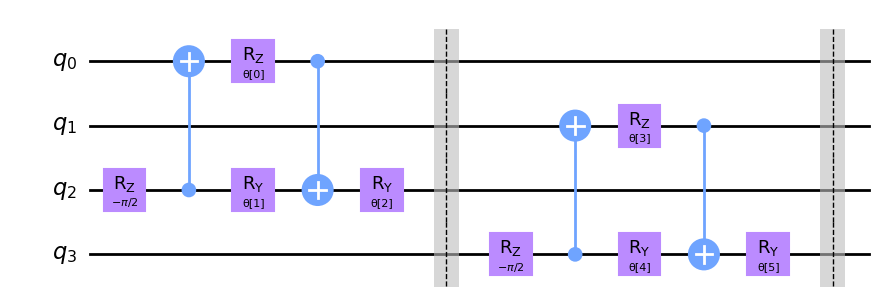

In [37]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

# Data generation

In [38]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(0)
            random_image = algorithm_globals.random.integers(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [39]:
images, labels = generate_dataset(64)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

batch_size = 1

# Create train loader for training
train_images_tensor = torch.tensor(np.array(train_images), dtype=torch.float32)
train_labels_tensor = torch.tensor(np.array(train_labels), dtype=torch.long)
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Create train loader for test set
test_images_tensor = torch.tensor(np.array(test_images), dtype=torch.float32)
test_labels_tensor = torch.tensor(np.array(test_labels), dtype=torch.long)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

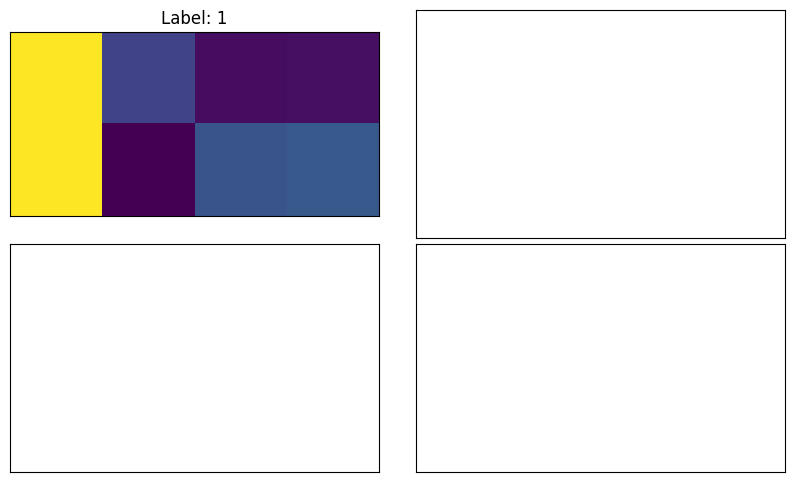

In [40]:
real_samples, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i, ax in enumerate(axes.flat):
  if i < real_samples.shape[0]:
    ax.imshow(real_samples[i].reshape(2,4),)
    ax.set_title(f'Label: {labels[i].item()}')
plt.subplots_adjust(wspace=0.1, hspace=0.025)
plt.show()

# Building module

In [41]:
feature_map = ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)

# Combining the feature map and ansatz
qc = QuantumCircuit(8)
qc.compose(feature_map, range(8), inplace=True)
qc.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=qc,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True,
)

In [42]:
# Define the model with a sigmoid activation function
class QNNModel(nn.Module):
    def __init__(self, qnn):
        super(QNNModel, self).__init__()
        self.qnn = TorchConnector(qnn)

    def forward(self, x):
        x = self.qnn(x)
        return torch.cat((x, 1 - x), -1)

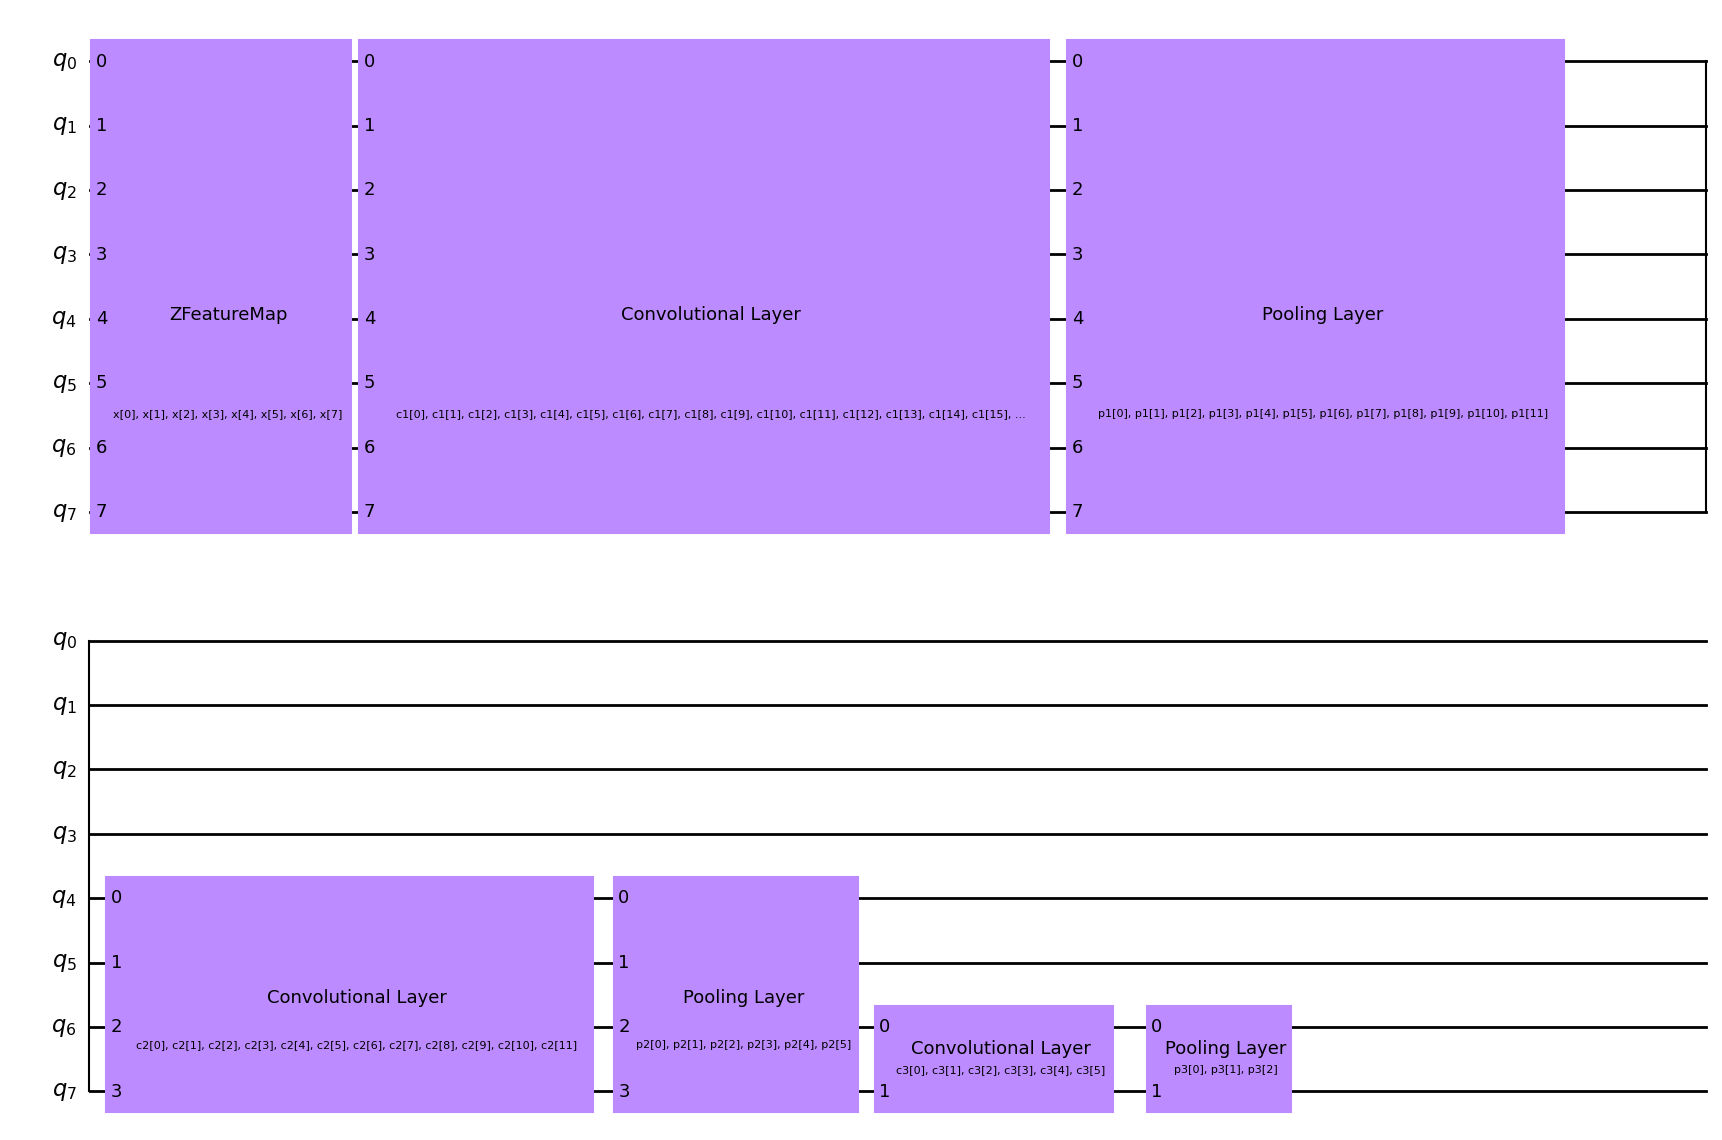

In [43]:
qc.draw("mpl", style="clifford")

# Training module

In [44]:
def callback_graph(epoch, obj_func_eval, accuracy=0):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()
    ax1.set_title(f"Objective function value against iteration (Epoch {epoch})")
    ax1.plot(obj_func_eval, label="generator loss", color="royalblue")
    ax1.legend(loc="best")

    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Accracy")
    ax2.grid()
    ax2.set_title(f"Relative entropy (Epoch {epoch})")
    ax2.plot(accuracy)

    plt.show()

In [45]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using cuda:', torch.cuda.get_device_name(device=device))
else:
  device = torch.device("cpu")
  print('Using cpu: aborded')
  exit()

Using cuda: NVIDIA GeForce RTX 4060 Laptop GPU


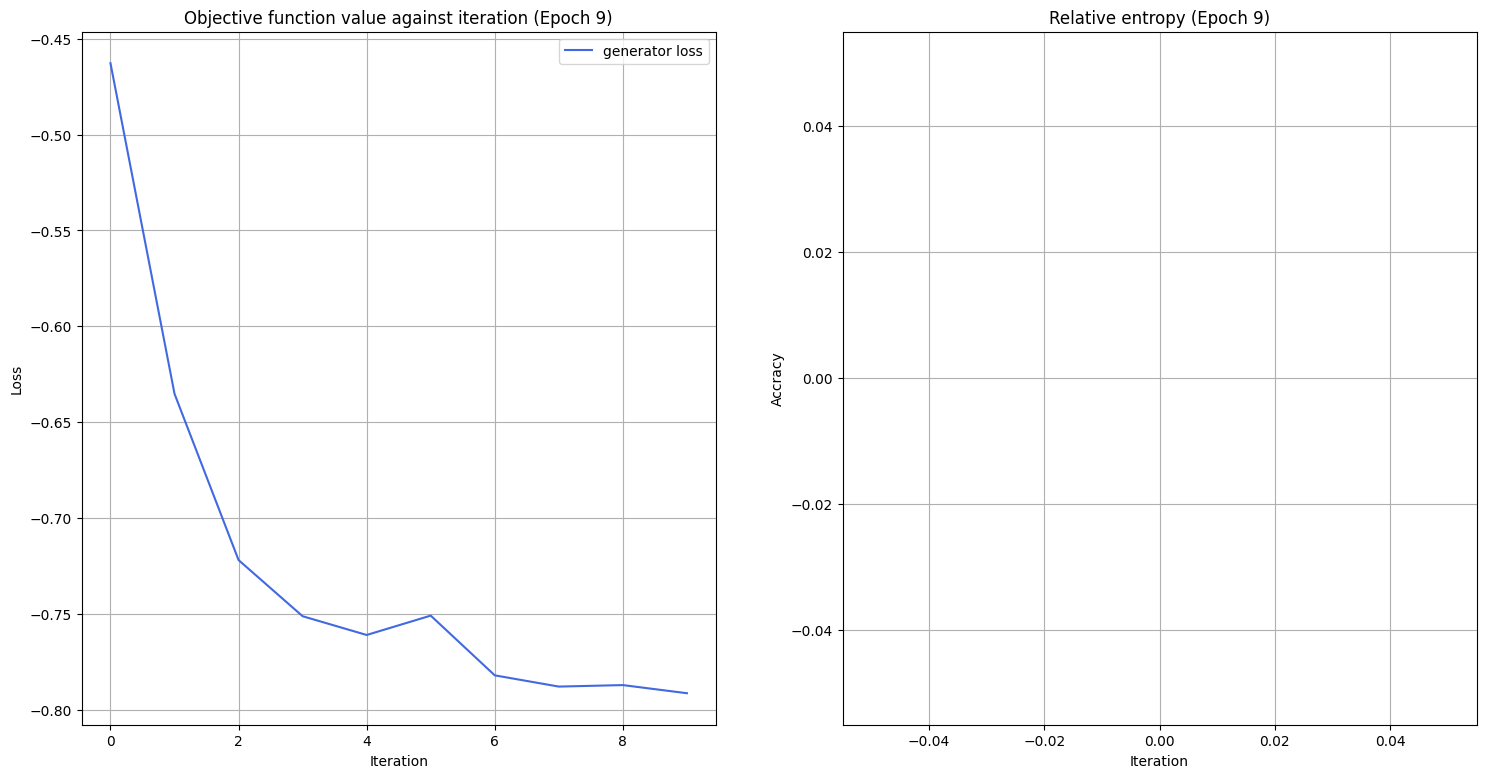

Training [100.0%] Epoch: 9, loss: -0.7913047522121236


In [47]:
# Define model, optimizer, and loss function
model = QNNModel(qnn).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.02)
loss_func = nn.NLLLoss()

# Training loop
epochs = 10
loss_list = []
model.train()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device=device), target.to(device=device)
        optimizer.zero_grad(set_to_none=True)  
        output = model(data)
        loss = loss_func(output, target) 
        loss.backward() 
        optimizer.step()  
        total_loss.append(loss.item())  
    loss_list.append(sum(total_loss) / len(total_loss))
    callback_graph(epoch, loss_list)
    print(f"Training [{100 * (epoch + 1) / epochs}%] Epoch: {epoch}, loss: {loss_list[-1]}")

# Testing module

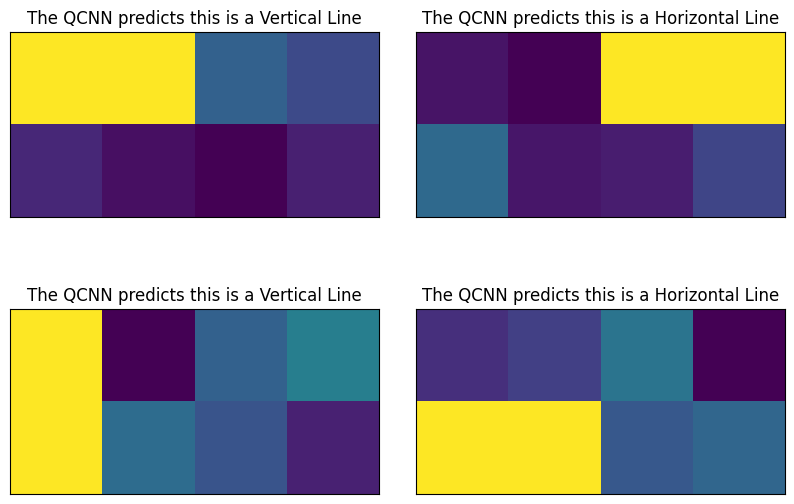

In [ ]:
model.eval()
predictions = []
targets = []
all_data = []
model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        predictions.extend(pred)
        targets.append(target)
        all_data.extend(data)

    fig, axes = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
    for i, ax in enumerate(axes.flat):
        ax.imshow(all_data[i].reshape(2, 4))
        if predictions[i].item() == 0:
            ax.set_title("The QCNN predicts this is a Horizontal Line")
        elif predictions[i].item() == 1:
            ax.set_title("The QCNN predicts this is a Vertical Line")

    plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [ ]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = len(predictions)

for i, predict in enumerate(predictions):
    if predict.item() == targets[i].item():
        correct += 1

accuracy = correct / total
print("Accuracy: ", accuracy * 100, "%")

Accuracy:  72.72727272727273 %
